In [1]:
# Load Data
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

data = pd.read_csv('../DATA/train_data.csv')
data.head()

c_temp_pv  k_rpm_pv  n_temp_pv  scale_pv  s_temp_pv
0       69.6       189       67.2      3.01       67.1
1       69.8       189       67.2      3.01       67.0
2       69.7       189       67.9      3.08       65.9
3       69.7       189       67.8      3.08       65.9
4       69.7       189       67.8      3.08       65.9

### 규제하지 않은 데이터

In [2]:
# 다중공선성 테스트
from statsmodels.stats.outliers_influence import variance_inflation_factor

data_for_vif = data.drop(['scale_pv'], axis=1)
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(data_for_vif.values, i) for i in range(data_for_vif.shape[1])]
vif["features"] = data_for_vif.columns
vif

VIF Factor   features
0  5191.463485  c_temp_pv
1   628.194449   k_rpm_pv
2  7325.967704  n_temp_pv
3  5334.673950  s_temp_pv

In [3]:
# 다중공선성이 높은 변수 제거
data_for_vif.drop('n_temp_pv', axis=1, inplace=True)
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(data_for_vif.values, i) for i in range(data_for_vif.shape[1])]
vif["features"] = data_for_vif.columns
vif

VIF Factor   features
0  3775.543341  c_temp_pv
1   616.216326   k_rpm_pv
2  2690.773622  s_temp_pv

In [4]:
# 다중공선성이 높은 변수 제거
data_for_vif.drop('c_temp_pv', axis=1, inplace=True)
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(data_for_vif.values, i) for i in range(data_for_vif.shape[1])]
vif["features"] = data_for_vif.columns
vif

VIF Factor   features
0  424.534497   k_rpm_pv
1  424.534497  s_temp_pv

In [21]:
# temp 만으로 다중공선성 확인
data_for_vif = data[['c_temp_pv', 'n_temp_pv', 's_temp_pv']]
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(data_for_vif.values, i) for i in range(data_for_vif.shape[1])]
vif["features"] = data_for_vif.columns
vif

VIF Factor   features
0  3659.708853  c_temp_pv
1  7186.279513  n_temp_pv
2  5329.484560  s_temp_pv

### data의 상관관계 분석
- 결론 : scale과는 상관관계가 거의 없고, 나머지 피처간 상관관계가 높아 다중공선성을 의심해봄
- 해결방안 : PCA를 통해 다중공선성을 해결해보자

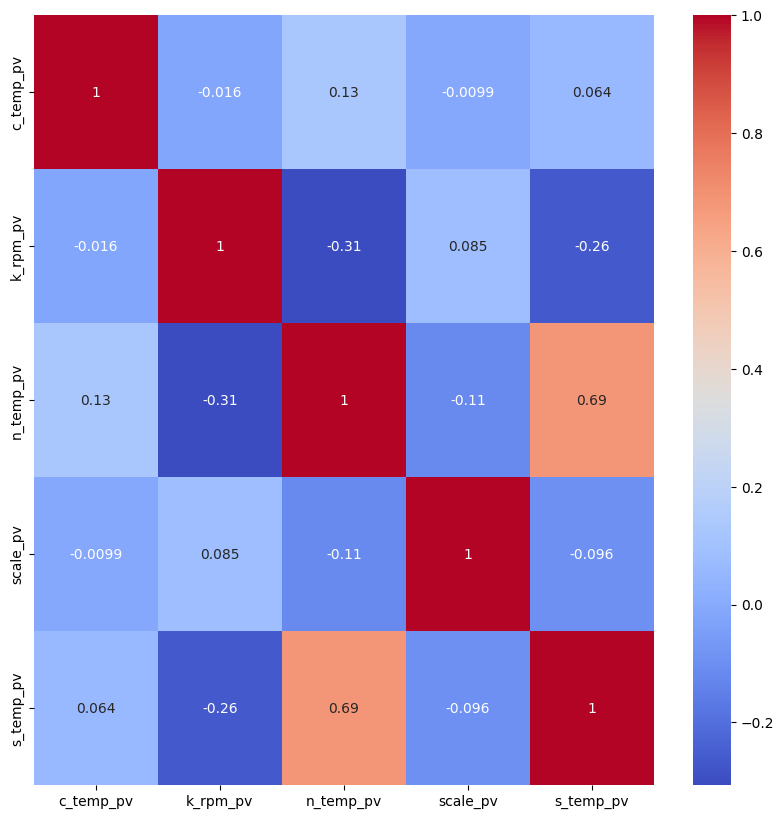

In [5]:
# data corr heatmap
plt.figure(figsize=(10, 10))
sns.heatmap(data.corr(), annot=True, cmap='coolwarm')
plt.show()

In [6]:
# 사실 2~4 규제하지 않으면 상관 관계를 규정할 수 없음

### PCA(Principal Component Analysis) : 주성분 분석
- 다중공선성을 해결하기 위해 PCA를 사용
- 여러 컬럼을 적은 수의 컬럼으로 압축
- PCA를 통해 압축된 데이터를 이용해 모델링

In [7]:
# PCA(주성분 분석)를 통한 차원 축소
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
data_scaled = scaler.fit_transform(data.drop(['scale_pv'], axis=1))

pca = PCA(n_components=2)
data_pca = pca.fit_transform(data_scaled)

data_pca = pd.DataFrame(data_pca, columns=['PC1', 'PC2'])
# reset index
data_pca.index = data.index
data_pca['scale_pv'] = data['scale_pv']
data_pca.head()

PC1       PC2  scale_pv
0 -1.354785  0.926646      3.01
1 -1.348325  0.548493      3.01
2 -1.512235  0.672374      3.08
3 -1.571052  0.673400      3.08
4 -1.571052  0.673400      3.08

In [8]:
# data_pca vif
data_pca_for_vif = data_pca.drop(['scale_pv'], axis=1)
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(data_pca_for_vif.values, i) for i in range(data_pca_for_vif.shape[1])]
vif["features"] = data_pca_for_vif.columns
vif

VIF Factor features
0         1.0      PC1
1         1.0      PC2

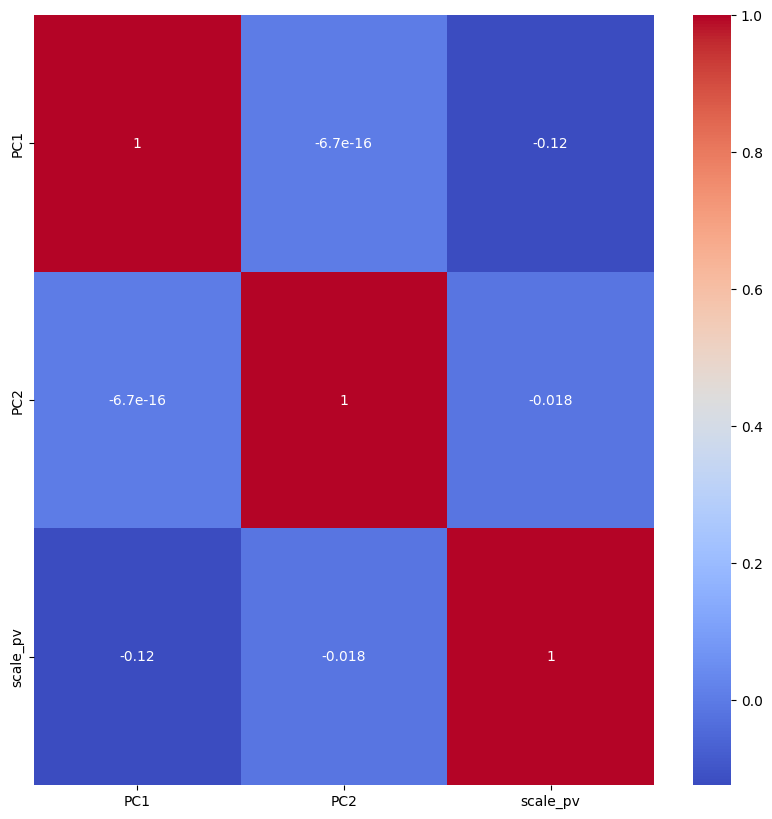

In [9]:
# corr heatmap
plt.figure(figsize=(10, 10))
sns.heatmap(data_pca.corr(), annot=True, cmap='coolwarm')
plt.show()

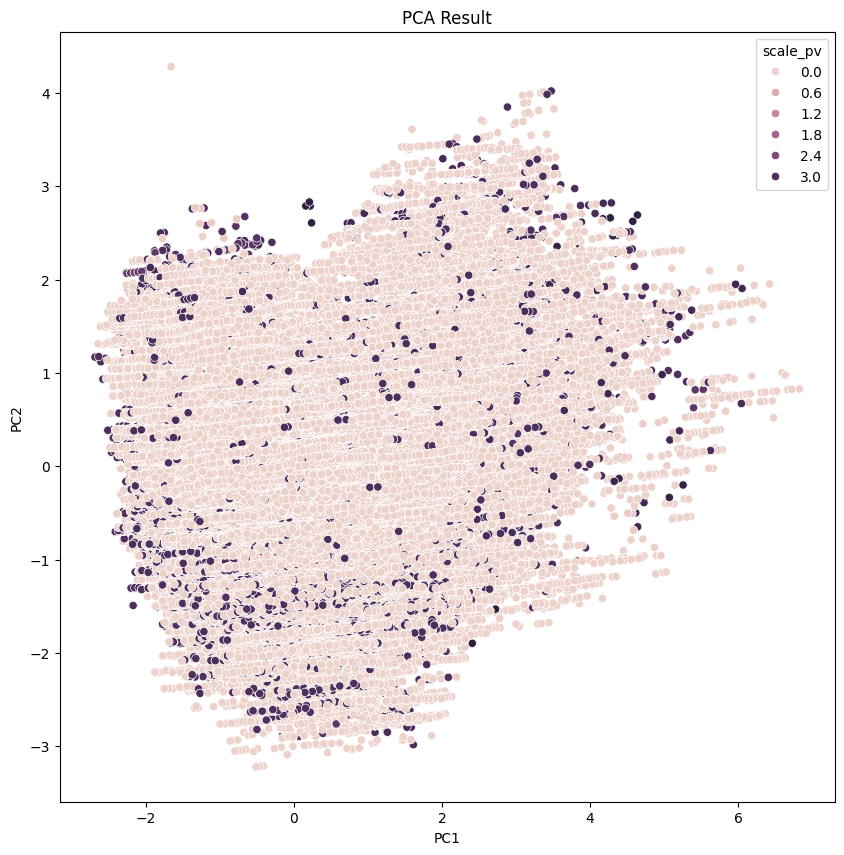

In [10]:
# PCA 결과 시각화
plt.figure(figsize=(10, 10))
sns.scatterplot(data=data_pca, x='PC1', y='PC2', hue='scale_pv')
plt.title('PCA Result')
plt.show()

### 규제한 데이터

In [11]:
# data load
data = pd.read_csv('../DATA/train_data.csv')

# scale : 2 ~ 4
data_2_4 = data[(data['scale_pv'] >= 2) & (data['scale_pv'] <= 4)]

# PCA
scaler = StandardScaler()
data_2_4_scaled = scaler.fit_transform(data_2_4.drop(['scale_pv'], axis=1))

pca = PCA(n_components=2)
data_2_4_pca = pca.fit_transform(data_2_4_scaled)

data_2_4_pca = pd.DataFrame(data_2_4_pca, columns=['PC1', 'PC2'])
# reset index
data_2_4_pca.index = data_2_4.index
data_2_4_pca['scale_pv'] = data_2_4['scale_pv']
data_2_4_pca.head()

PC1       PC2  scale_pv
0 -1.241010  0.363331      3.01
1 -1.162645  0.042563      3.01
2 -1.316360  0.085097      3.08
3 -1.388302  0.087082      3.08
4 -1.388302  0.087082      3.08

In [12]:
data_2_4.shape, data_2_4_pca.shape

((36721, 5), (36721, 3))

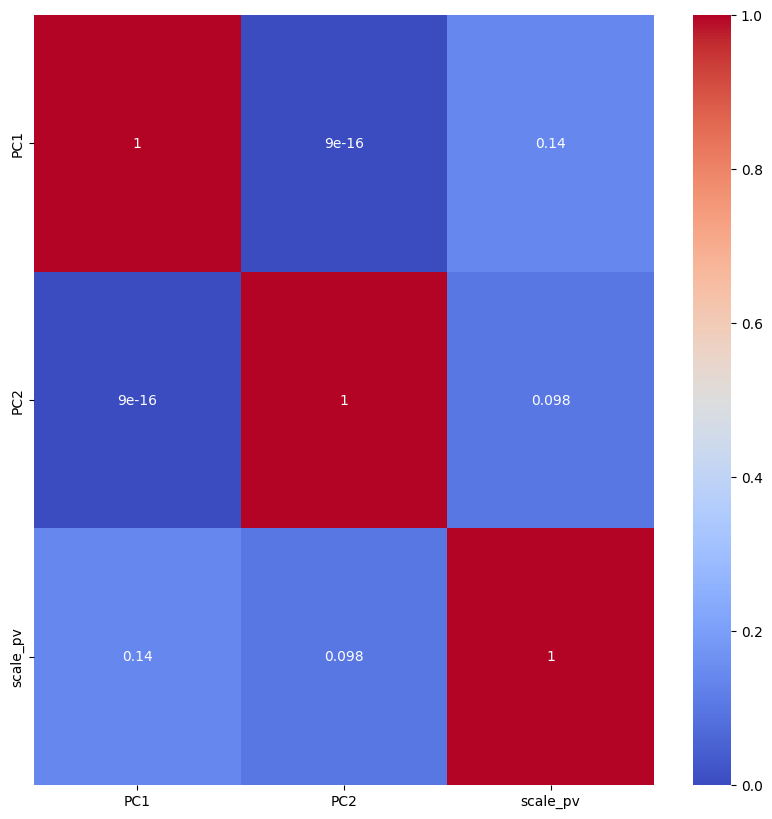

In [13]:
# corr heatmap
plt.figure(figsize=(10, 10))
sns.heatmap(data_2_4_pca.corr(), annot=True, cmap='coolwarm')
plt.show()

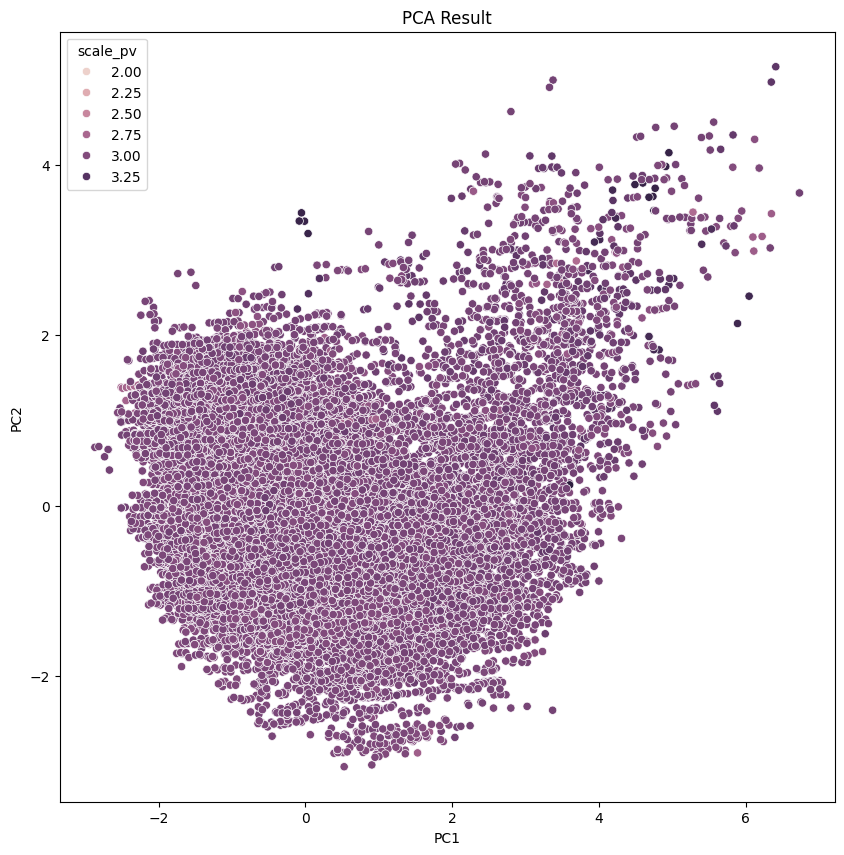

In [14]:
# PCA 결과 시각화
plt.figure(figsize=(10, 10))
sns.scatterplot(data=data_2_4_pca, x='PC1', y='PC2', hue='scale_pv')
plt.title('PCA Result')
plt.show()

In [15]:
# viff of data_2_4
data_2_4_for_vif = data_2_4.drop(['scale_pv'], axis=1)
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(data_2_4_for_vif.values, i) for i in range(data_2_4_for_vif.shape[1])]
vif["features"] = data_2_4_for_vif.columns
vif

VIF Factor   features
0  7113.401348  c_temp_pv
1   614.959738   k_rpm_pv
2  8906.037094  n_temp_pv
3  5338.386844  s_temp_pv

In [16]:
# data_2_4_pca 의 vif
data_2_4_pca_for_vif = data_2_4_pca.drop(['scale_pv'], axis=1)
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(data_2_4_pca_for_vif.values, i) for i in range(data_2_4_pca_for_vif.shape[1])]
vif["features"] = data_2_4_pca_for_vif.columns
vif

VIF Factor features
0         1.0      PC1
1         1.0      PC2

### PCA + 규제 모델 학습

In [17]:
data_2_4_pca

PC1       PC2  scale_pv
0      -1.241010  0.363331      3.01
1      -1.162645  0.042563      3.01
2      -1.316360  0.085097      3.08
3      -1.388302  0.087082      3.08
4      -1.388302  0.087082      3.08
...          ...       ...       ...
200095 -1.897498  0.679605      3.06
200096 -1.963556  0.835469      3.06
200105 -1.867080  1.006053      3.06
200106 -1.920831  0.997013      3.06
200107 -1.848888  0.995029      3.06

[36721 rows x 3 columns]

In [18]:
# 결측값 문제; data_2_4_pca
data_2_4_pca.isnull().sum() # 해결! 

PC1         0
PC2         0
scale_pv    0
dtype: int64

In [19]:
# 모델 학습 및 평가
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, r2_score
from sklearn.ensemble import RandomForestRegressor

X = data_2_4_pca.drop(['scale_pv'], axis=1)
y = data_2_4_pca['scale_pv']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

models = {
    'Linear Regression': LinearRegression(),
    'Random Forest': RandomForestRegressor()
}

for model_name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    mape = mean_absolute_percentage_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    print(f'{model_name} - MAE: {mae:.4f}, MAPE: {mape*100:.4f}, R2: {r2:.4f}')


Linear Regression - MAE: 0.0264, MAPE: 0.8740, R2: 0.0320
Random Forest - MAE: 0.0264, MAPE: 0.8732, R2: 0.0754


In [20]:
# 성능이 나쁘진 않지만 KNN 보다 극명히 좋진 않다

# data_2_4의 scale_pv describe
data_2_4['scale_pv'].describe()

count    36721.000000
mean         3.041585
std          0.039304
min          2.000000
25%          3.020000
50%          3.040000
75%          3.060000
max          3.490000
Name: scale_pv, dtype: float64